In [60]:
from scipy import stats
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas_profiling as pp
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, roc_auc_score, make_scorer, f1_score, recall_score, roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
import os
os.environ['PYTHONHASHSEED']=str(271828)
random.seed(271828)
np.random.seed(271828)
#import tensorflow as tf
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from tensorflow.python.framework import ops
import tensorflow as tf
tf.random.set_seed(271828)
ops.reset_default_graph()
from fancyimpute import IterativeImputer

from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
#from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

import keras.backend as K
#session_conf=tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1) 
#sesCriticalSection=tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

In [61]:
def PCL_calculator(df):

    symptomatic_cutoff = 2

    intrusion = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH', 'q6.4_UPSET', 'q6.5_PHYS']
    avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES', 'q6.9_DISINT', 'q6.10_DTACH',
                 'q6.11_NUMB', 'q6.12_FUTRE']
    tred = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH']
    only_avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES']

    hypertension = ['q6.13_SLEEP', 'q6.14_ANGER', 'q6.15_CONC', 'q6.16_HYPER', 'q6.17_STRTL']

    depression = ['q6.9_DISINT', 'q6.10_DTACH', 'q6.11_NUMB', 'q6.12_FUTRE']

    df[intrusion + avoidance + hypertension].fillna(df[intrusion + avoidance + hypertension].mean(axis=1))
    intrusion_cuoff = 1
    avoidance_cuoff = 3
    hypertension_cuoff = 2
    only_avoidance_cutoff = 1
    depression_cutoff = 2
    tred_cutoff = 1

    df['sum'] = (df[intrusion + avoidance + hypertension]).sum(axis=1)

    df['intrusion'] = (df[intrusion] > symptomatic_cutoff).sum(axis=1)
    df['intrusion_cutoff'] = (df['intrusion'] >= intrusion_cuoff).astype(int)

    df['avoidance'] = (df[avoidance] > symptomatic_cutoff).sum(axis=1)
    df['avoidance_cutoff'] = (df['avoidance'] >= avoidance_cuoff).astype(int)

    df['depression'] = (df[depression] > symptomatic_cutoff).sum(axis=1)
    df['depression_cutoff'] = df['depression'] >= depression_cutoff

    df['hypertention'] = (df[hypertension] > symptomatic_cutoff).sum(axis=1)
    df['hypertention_cutoff'] = (df['hypertention'] >= hypertension_cuoff).astype(int)

    df['tred'] = (df[tred] > symptomatic_cutoff).sum(axis=1)
    df['tred_cutoff'] = df['tred'] >= tred_cutoff

    df['only_avoidance'] = (df[only_avoidance] > symptomatic_cutoff).sum(axis=1)
    df['only_avoidance_cutoff'] = df['only_avoidance'] >= only_avoidance_cutoff

    df['regression_cutoff_33'] = df['sum'] >= 33
    df['regression_cutoff_50'] = df['sum'] >= 49
    df['diagnosis'] = ((df['hypertention_cutoff']) & (df['avoidance_cutoff']) & (df['intrusion_cutoff']) & (df['sum'] >= 49))

    return df


In [73]:
path = "C:\‏‏PycharmProjects\PTSD\Data\PTSD.xlsx"
df = pd.read_excel(path)
#combine with specifics of answers
df_pcl2 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL2.xlsx")
df_pcl1 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL1.xlsx")
df = df.merge(df_pcl1, on="ID", how='outer')
df = df.merge(df_pcl2, suffixes=('_pcl1', '_pcl2'), on="ID", how='outer')

df_pcl3 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL3.xlsx")
df_pcl3 = PCL_calculator(df_pcl3)
df = df.merge(df_pcl3.drop(['PCL3_Strict', 'pcl3', 'PCL3_Broad'], axis=1), on="ID", how='outer')
# rmoving missing Y's
df = df[~df['tred_cutoff'].isna()]

In [74]:
# removed age
features = ["highschool_diploma", "dyslexia", "ADHD", "Ashken_scale", "Sephar_scale", "Unknown_scale",
            "T1Acc1t", "T1Acc1n", "T1bias", "phq1", "lot1", "trait1", "state1", "PCL1",
            "PCL_Broad1", "PCL_Strict1", "phq2", "lot2", "trait2", "state2", "PCL2",
            "PCL_Broad2", "PCL_Strict2", "cd_risc1", "active_coping1", "planning1",
            "positive_reframing1", "acceptance1", "humor1", "religion1", "emotional_support1",
            "instrumental_support1", "self_distraction1", "denial1", "venting1", "substance_use1",
            "behavioral_disengagement1", "self_blame1", "active_coping2", "planning2",
                "positive_reframing2", "acceptance2", "humor2", "religion2", "emotional_support2",
                "instrumental_support2", "self_blame2", "self_distraction2", "denial2",
            "venting2", "substance_use2", "behavioral_disengagement2",
                "trauma_history8_1", "HML_5HTT", "HL_MAOA", "HML_NPY", "COMT_Hap1_recode",
                "COMT_Hap2_recode", "COMT_Hap1_LvsMH", "HML_FKBP5", 'q6.1_INTRU_pcl1', 
                'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                  'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                  'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                  'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                  'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                  'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                  'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                  'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2']

In [75]:
t2_features = [
    "lot2", "trait2", "state2", "PCL2", "PCL_Broad2", "PCL_Strict2", "phq2",

    "active_coping2", "planning2", "positive_reframing2", "acceptance2", "humor2", 
    "religion2", "emotional_support2", "instrumental_support2", "self_distraction2",
    "denial2", "venting2", "substance_use2", "behavioral_disengagement2", "self_blame2",
    
    'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2', 'q6.5_PHYS_pcl2',
    'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                    'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                    'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2'
]
t1_features =[ "phq1", "lot1", "trait1","state1", "PCL1", "PCL_Broad1", "PCL_Strict1",
              
                    "active_coping1", "planning1", "positive_reframing1", "acceptance1", "humor1", "religion1",
                    "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                    "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1",
                'q6.1_INTRU_pcl1', 'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                    'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                    'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                    'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1']

In [76]:
discrete_features = ["highschool_diploma", "dyslexia", "ADHD", "phq1", "lot1",
                    "trait1", "state1", "PCL1", "PCL_Broad1", "PCL_Strict1", "phq2", "lot2",
                    "trait2", "state2", "PCL2", "PCL_Broad2", "PCL_Strict2", "cd_risc1", "active_coping1",
                    "planning1", "positive_reframing1", "acceptance1", "humor1", "religion1",
                    "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                    "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1", "active_coping2",
                    "planning2", "positive_reframing2", "acceptance2", "humor2", "religion2", "emotional_support2",
                    "instrumental_support2", "self_distraction2", "denial2", "venting2", "substance_use2",
                    "behavioral_disengagement2", "self_blame2", "trauma_history8_1",
                    'q6.1_INTRU_pcl1', 'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                    'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                    'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                    'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                    'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                    'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                    'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                    'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2']

In [77]:
genome_features = ["HML_5HTT", "HL_MAOA", "HML_NPY", "COMT_Hap1_recode",
                "COMT_Hap2_recode", "COMT_Hap1_LvsMH", "HML_FKBP5"]
continuous_features = ["T1Acc1t", "T1Acc1n", "T1bias"]
demographic_features = ["highschool_diploma", "dyslexia", "ADHD", "Ashken_scale", "Sephar_scale", "Unknown_scale"]

In [78]:
df1 = df[features + ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH', 'tred_cutoff']]
#df1 = df1.dropna(thresh=47)
df_t1 = df1[t1_features]
df_t2 = df1[t2_features]
df1 = df1[(df_t1.isna().astype(int).sum(axis=1)<38) | (df_t2.isna().astype(int).sum(axis=1)<38)]
df1["t1_missing"] = df_t1.isna().astype(int).sum(axis=1)==38
df1["t2_missing"] = df_t2.isna().astype(int).sum(axis=1)==38
features.extend(["t1_missing", "t2_missing"])


In [79]:
impute = 1
if impute:
    mice = IterativeImputer()
    df1 = pd.DataFrame(mice.fit_transform(df1), columns=df1.columns)

#    outlier_relevant_features = ["PCL2", "substance_use2", "behavioral_disengagement2",
 #   "q6.12_FUTRE_pcl1", "q6.3_FLASH_pcl2", "q6.5_PHYS_pcl2", "q6.17_STRTL_pcl1",
  #  "q6.7_AVSIT_pcl2", "q6.12_FUTRE_pcl2", "q6.13_SLEEP_pcl2", "q6.8_AMNES_pcl1",
   # "q6.14_ANGER_pcl2", "q6.15_CONC_pcl2"]
   # features.extend(["outliers_count", "specific_features_outliers"])
   # df1["outliers_count"] = (np.abs(stats.zscore(df1)) > 3).sum(axis=1)
    #df1["specific_features_outliers"] = (np.abs(stats.zscore(df1[outlier_relevant_features])) > 3).sum(axis=1)
    
    #df1 = df1[(np.abs(stats.zscore(df1)) > 3).sum(axis=1)<15]

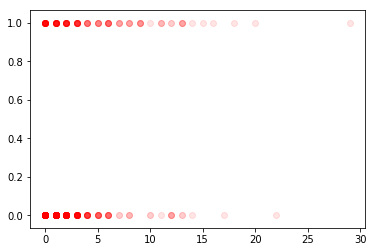

In [80]:
plt.scatter((np.abs(stats.zscore(df1)) > 3).sum(axis=1), df1['tred_cutoff'], alpha=0.1, c="r")

In [81]:
# t1 PTSD ratio with full missing values
13/(13+43)

0.23214285714285715

In [82]:
# t2 PTSD ratio with full missing values
38/157

0.24203821656050956

In [347]:
outlier_relevant_features = ["PCL2", "substance_use2", "behavioral_disengagement2",
    "q6.12_FUTRE_pcl1", "q6.3_FLASH_pcl2", "q6.5_PHYS_pcl2", "q6.17_STRTL_pcl1",
    "q6.7_AVSIT_pcl2", "q6.12_FUTRE_pcl2", "q6.13_SLEEP_pcl2", "q6.8_AMNES_pcl1",
    "q6.14_ANGER_pcl2", "q6.15_CONC_pcl2"]
features.extend(["outliers_count", "specific_features_outliers"])
df1["outliers_count"] = (np.abs(stats.zscore(df1)) > 3).sum(axis=1)
df1["specific_features_outliers"] = (np.abs(stats.zscore(df1[outlier_relevant_features])) > 3).sum(axis=1)

In [101]:
df_na = pd.DataFrame((np.abs(stats.zscore(df1)) > 3), columns=features+['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH', 'tred_cutoff'])
df_na["tred_cutoff"] = df1["tred_cutoff"].values.astype(int)
#sum(df1["tr(np.abs(stats.zscore(df1)) > 3)ed_cutoff"].isna().astype(int))

In [103]:
df_na.corr()["tred_cutoff"].abs()[df_na.corr()["tred_cutoff"].abs()> 0.2]

PCL_Broad2          0.234180
PCL_Strict2         0.233373
q6.3_FLASH_pcl2     0.200835
q6.13_SLEEP_pcl2    0.226524
q6.15_CONC_pcl2     0.205071
t1_missing          0.299312
t2_missing          0.411487
q6.1_INTRU          0.443318
tred_cutoff         1.000000
Name: tred_cutoff, dtype: float64

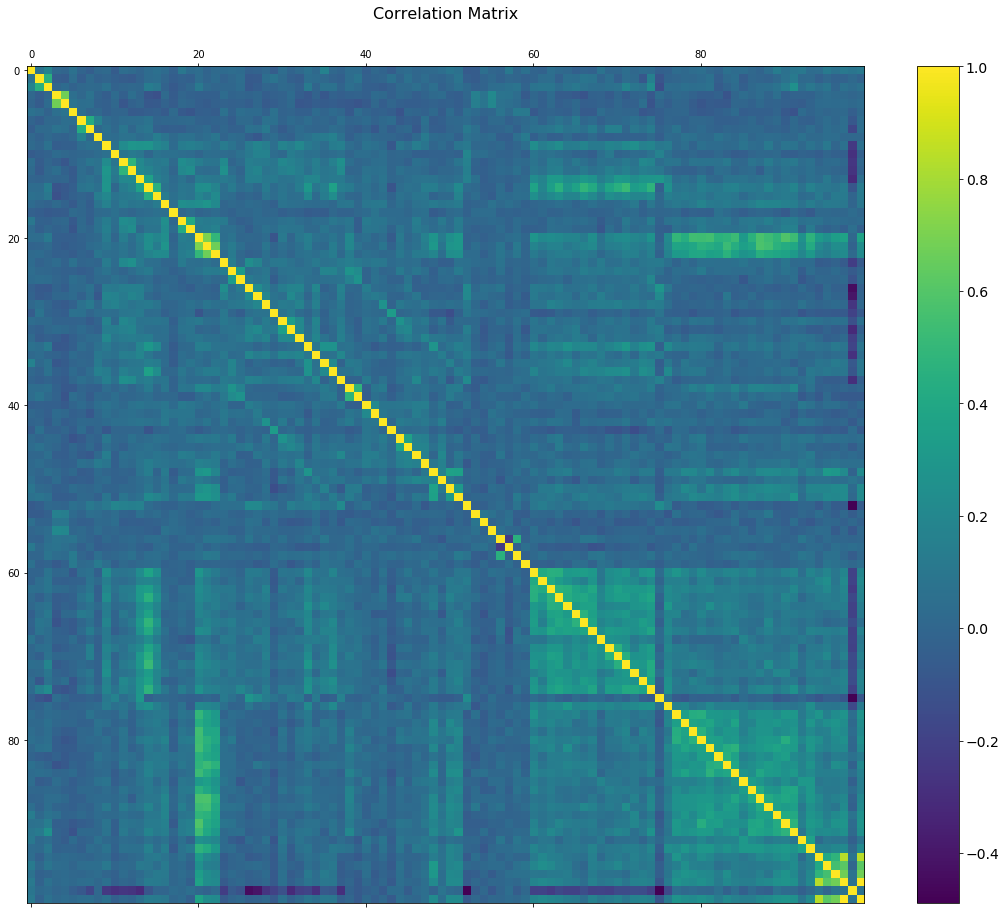

In [90]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_na.corr(), fignum=f.number)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [55]:
#pp.ProfileReport(df1)

In [252]:
df_na.corr()["tred_cutoff"]

highschool_diploma     NaN
dyslexia               NaN
ADHD                   NaN
Ashken_scale           NaN
Sephar_scale           NaN
Unknown_scale          NaN
T1Acc1t                NaN
T1Acc1n                NaN
T1bias                 NaN
phq1                   NaN
lot1                   NaN
trait1                 NaN
state1                 NaN
PCL1                   NaN
PCL_Broad1             NaN
PCL_Strict1            NaN
phq2                   NaN
lot2                   NaN
trait2                 NaN
state2                 NaN
PCL2                   NaN
PCL_Broad2             NaN
PCL_Strict2            NaN
cd_risc1               NaN
active_coping1         NaN
planning1              NaN
positive_reframing1    NaN
acceptance1            NaN
humor1                 NaN
religion1              NaN
                      ... 
q6.6_AVTHT_pcl1        NaN
q6.7_AVSIT_pcl1        NaN
q6.8_AMNES_pcl1        NaN
q6.9_DISINT_pcl1       NaN
q6.10_DTACH_pcl1       NaN
q6.11_NUMB_pcl1        NaN
q

In [10]:
xgb = XGBClassifier()

In [11]:
xgb.fit(df1[features], df1["tred_cutoff"])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [12]:
#xgb.predict(df1[features]).astype(int)
#df1["tred_cutoff"].values
roc_auc_score(xgb.predict(df1[features]).astype(int), df1["tred_cutoff"].values.astype(int))

0.9905982905982905

In [40]:
xgb = XGBClassifier()
scv = StratifiedKFold(5)
cross_val_score(xgb, df1[features], df1["tred_cutoff"].values.astype(int), cv=scv, scoring='roc_auc')

KeyError: 'tred_cutoff'

In [56]:
xgb = XGBClassifier()
scv = StratifiedKFold(5)
cross_val_score(xgb, df1[features], (df1['q6.3_FLASH']>2).values.astype(int), cv=scv, scoring='roc_auc').mean()

0.8459560493640218

In [310]:
(np.abs(stats.zscore(df1)) > 3).shape

(704, 97)

In [57]:
xgb = XGBClassifier()
scv = StratifiedKFold(5)
cross_val_score(xgb, df1[features], (df1['q6.2_DREAM']>2).values.astype(int), cv=scv, scoring='roc_auc').mean()

0.8186938255542906

In [58]:
xgb = XGBClassifier()
scv = StratifiedKFold(5)
cross_val_score(xgb, df1[features], (df1['q6.1_INTRU']>2).values.astype(int), cv=scv, scoring='roc_auc').mean()

0.7690789651951311

In [240]:
? cross_val_score